In [3]:
#Define the model.
import torch

import NF #module for normalizing flows
import BAM #module for blockwise autoregressive monotonic transformations

mylayers = [BAM.LinearWeightNorm([1,1], [10,10]), BAM.Tanh([10,10]),
            BAM.LinearWeightNorm([10,10], [10,10]), BAM.Tanh([10,10]),
            BAM.LinearWeightNorm([10,10], [10,10]), BAM.Tanh([10,10]),
            BAM.LinearWeightNorm([10,10], [10,10]), BAM.Tanh([10,10]),
            BAM.LinearWeightNorm([10,10], [1,1]), BAM.Gate([1,1])
           ]

mystack = BAM.Stack(*mylayers)

mycat = BAM.Cat(mystack, BAM.Gate([1,1]))

mysum = BAM.Stack(mycat, BAM.Sum([2,2]))

mynet = mysum.NF()

mylayers = [BAM.LinearWeightNorm([1,1], [10,10]), BAM.Tanh([10,10]),
            BAM.LinearWeightNorm([10,10], [10,10]), BAM.Tanh([10,10]),
            BAM.LinearWeightNorm([10,10], [10,10]), BAM.Tanh([10,10]),
            BAM.LinearWeightNorm([10,10], [10,10]), BAM.Tanh([10,10]),
            BAM.LinearWeightNorm([10,10], [1,1]), BAM.Gate([1,1])
           ]

mystack = BAM.Stack(*mylayers)

mycat = BAM.Cat(mystack, BAM.Gate([1,1]))

mysum = BAM.Stack(mycat, BAM.Sum([2,2]))

mynet2 = mysum.NF()

mynet = NF.Stack(NF.Rotation(0,1), NF.Tanh(), mynet, NF.Rotation(0,1), NF.Tanh(), mynet2)

#I put NF.Tanh before each of the BAM.Stacks to make sure the BAM modules receive
# normailzed input so bisection can be initialized with a known range of (-1,+1).
# Alternatively, I can change mynet.bisection_minimum and maximum to large enough values.

#NF.Rotation modules can e.g. be replaced with NF.Permutation.

mynet

NF:Stack(
  (0): NF:Rotation()
  (1): NF:Tanh()
  (2): NF:FromBAM(
    (_net): BAM:Stack [1, 1] -> [1, 1](
      (0): BAM:Cat [1, 1] -> [2, 2](
        (0): BAM:Stack [1, 1] -> [1, 1](
          (0): BAM:LinearWeightNorm [1, 1] -> [10, 10]()
          (1): BAM:Tanh [10, 10] -> [10, 10]()
          (2): BAM:LinearWeightNorm [10, 10] -> [10, 10]()
          (3): BAM:Tanh [10, 10] -> [10, 10]()
          (4): BAM:LinearWeightNorm [10, 10] -> [10, 10]()
          (5): BAM:Tanh [10, 10] -> [10, 10]()
          (6): BAM:LinearWeightNorm [10, 10] -> [10, 10]()
          (7): BAM:Tanh [10, 10] -> [10, 10]()
          (8): BAM:LinearWeightNorm [10, 10] -> [1, 1]()
          (9): BAM:Gate [1, 1] -> [1, 1]()
        )
        (1): BAM:Gate [1, 1] -> [1, 1]()
      )
      (1): BAM:Sum [2, 2] -> [1, 1]()
    )
  )
  (3): NF:Rotation()
  (4): NF:Tanh()
  (5): NF:FromBAM(
    (_net): BAM:Stack [1, 1] -> [1, 1](
      (0): BAM:Cat [1, 1] -> [2, 2](
        (0): BAM:Stack [1, 1] -> [1, 1](
          (

In [4]:
#Train the model on the "moons" dataset from scikit-learn.
device = torch.device("cuda")
prior = torch.distributions.MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))
mygen = NF.ToGenerator(mynet, prior).to(device)
optimizer = torch.optim.Adam(mygen.parameters())
batches = 10000
batchsize = 100

import sklearn.datasets
import numpy

for t in range(batches):
  noisy_moons = torch.from_numpy(sklearn.datasets.make_moons(n_samples=batchsize, noise=0.05)[0].astype(numpy.float32)).to(device)
  loss = mygen.crossentropy_loss(noisy_moons)
  optimizer.zero_grad()
  loss.backward()
  if (t%500 == 0):
    print(t, loss.item())
  optimizer.step()

0 13.04084587097168
500 3.218587636947632
1000 2.2142059803009033
1500 1.515616774559021
2000 1.0264484882354736
2500 0.94846510887146
3000 0.9204378128051758
3500 0.7725324630737305
4000 0.7748315334320068
4500 1.0174421072006226
5000 0.8909194469451904
5500 0.5401074290275574
6000 0.6920161247253418
6500 0.5629801154136658
7000 0.5827810764312744
7500 0.4851115942001343
8000 0.5634927749633789
8500 0.5129310488700867
9000 0.5041109919548035
9500 0.6050083637237549


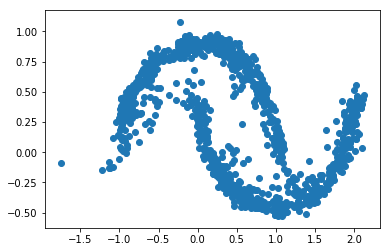

In [5]:
#Generate samples from the learned distribution.

import matplotlib.pyplot as plt

x = mygen.sample(1000).detach().cpu().numpy()
plt.scatter(x[:,0], x[:,1])

In [6]:
#Helper functions for initialization of (stacks of) coupling layers.
import torch

import NF #module for normalizing flows

def create_mask(n, p=0.5):
  idx = torch.randperm(n)
  mask = torch.where(idx > p * (n - 1), torch.ones_like(idx), torch.zeros_like(idx)).bool()
  return mask

def create_t(n, h=[256,256]):
  net = torch.nn.Linear(n, h[0])
  for layer in range(1, len(h)):
    net = torch.nn.Sequential(net, torch.nn.LeakyReLU(), torch.nn.Linear(h[layer-1], h[layer]))
  net = torch.nn.Sequential(net, torch.nn.LeakyReLU(), torch.nn.Linear(h[-1], n))
  return net

def create_s(n, h=[256,256]):
  net = create_t(n, h)
  net = torch.nn.Sequential(net, torch.nn.Tanh())
  return net
  
def create_2cl(n, p=0.5, ht=[256,256], hs=[256,256]):
  mask = create_mask(n, p)
  t1 = create_t(n, ht)
  t2 = create_t(n, ht)
  s1 = create_s(n, hs)
  s2 = create_s(n, hs)
  cl1 = NF.CouplingLayer(s1, t1, mask)
  cl2 = NF.CouplingLayer(s2, t2, ~mask)
  return NF.Stack(cl1, cl2)

def create_flownet(n, d=3, p=None, ht=None, hs=None):
  if p is None: p = [0.5] * d
  if ht is None: ht = [[256,256]] * d
  if hs is None: hs = [[256,256]] * d
  assert(len(p) == len(ht) == len(hs) == d)
  net = create_2cl(n, p[0], ht[0], hs[0])
  for i in range(1, d):
    net.add_module(str(i), create_2cl(n, p[i], ht[i], hs[i]))
  return net

n = 2
mynet = create_flownet(n)

mynet

NF:Stack(
  (0): NF:CouplingLayer(
    (_s): Sequential(
      (0): Sequential(
        (0): Sequential(
          (0): Linear(in_features=2, out_features=256, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
          (2): Linear(in_features=256, out_features=256, bias=True)
        )
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=256, out_features=2, bias=True)
      )
      (1): Tanh()
    )
    (_t): Sequential(
      (0): Sequential(
        (0): Linear(in_features=2, out_features=256, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=256, out_features=256, bias=True)
      )
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=256, out_features=2, bias=True)
    )
  )
  (1): NF:Stack(
    (0): NF:CouplingLayer(
      (_s): Sequential(
        (0): Sequential(
          (0): Sequential(
            (0): Linear(in_features=2, out_features=256, bias=True)
            (1): LeakyReLU(negative_

In [7]:
#Train model on the "moons" dataset from scikit-learn.
device = torch.device("cuda")
prior = torch.distributions.MultivariateNormal(torch.zeros(n).to(device), torch.eye(n).to(device))
mygen = NF.ToGenerator(mynet, prior).to(device)
optimizer = torch.optim.Adam(mygen.parameters())
batches = 10000
batchsize = 100

import sklearn.datasets
import numpy

for t in range(batches):
  noisy_moons = torch.from_numpy(sklearn.datasets.make_moons(n_samples=batchsize, noise=0.05)[0].astype(numpy.float32)).to(device)
  #we need noise because data distribution needs to be smooth enough for our model to fit
  loss = mygen.crossentropy_loss(noisy_moons)
  optimizer.zero_grad()
  loss.backward()
  if (t%500 == 0):
    print(t, loss.item())
  optimizer.step()

0 2.4339427947998047
500 0.896102249622345
1000 0.7639908194541931
1500 0.8175146579742432
2000 0.6856548190116882
2500 0.7319701910018921
3000 0.5654301047325134
3500 0.5522643327713013
4000 0.5686569213867188
4500 0.6733044385910034
5000 0.6473531723022461
5500 0.7102291584014893
6000 0.7783800363540649
6500 0.6996433138847351
7000 0.6084856390953064
7500 0.804218590259552
8000 0.7189302444458008
8500 1.0684806108474731
9000 0.7576208114624023
9500 0.6563704609870911


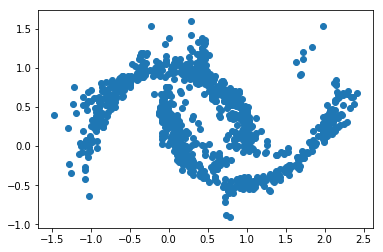

In [9]:
#Generate samples from learned distribution.
import matplotlib.pyplot as plt

x = mygen.sample(1000).detach().cpu().numpy()
plt.scatter(x[:,0], x[:,1])